In [1]:
#Input Data: 
#these are netcdf files of model data. Unique my model/season. Each contains multiple climate variables
modelDataPath = '/Data/Model/' 

import numpy      as np
import os
import pandas     as pd
import regionmask as rm
import warnings
import xarray     as xr

warnings.filterwarnings('ignore')
print("Packages Loaded")

Packages Loaded


In [2]:
#Set Working Directory
wd = '/Users/chrishancock/Library/CloudStorage/OneDrive-NorthernArizonaUniversity/Research/Manuscript/HoloceneHydroclimate/HoloceneHydroclimate/'
os.chdir(wd)
print('Working directory set to: '+wd)

Working directory set to: /Users/chrishancock/Library/CloudStorage/OneDrive-NorthernArizonaUniversity/Research/Manuscript/HoloceneHydroclimate/HoloceneHydroclimate/


In [3]:
#Load Data
modelData = {}
for model in ['hadcm','trace','cmip6']:
    modelData[model] = {}
    for szn in ['ANN','JJA','DJF']:
        if model == 'cmip6': end = '.nc'
        else:                end =  '_regrid.nc'
        handle = xr.open_dataset('Data/Model/'+model+'/'+model+'_'+szn+end,decode_times=False)
        modelData[model][szn] = handle
        handle.close()
        if end == '_regrid.nc':
            modelData[model][szn]=modelData[model][szn].rename({'pre_regrid':'pre','tas_regrid':'tas',
                                                                'p-e_regrid':'p-e','evp_regrid':'evp',
                                                                'lat':'lat','lon':'lon'})
    print(model+" "+str(sorted([i for i in modelData[model][szn].data_vars]))+' loaded')

hadcm ['evp', 'p-e', 'pre', 'tas'] loaded
trace ['evp', 'p-e', 'pre', 'tas'] loaded
cmip6 ['evp', 'p-e', 'pre', 'tas'] loaded


In [4]:
#A function to calculate the mean value of gridcells weighted by lat (change geo=land to do land only gridcells)
def maskmodeldata(values,lats,lons,geo='all'):
    #Lat weights
    wghts  = np.cos(np.deg2rad(lats))
    #IPCC ref regions
    refReg = rm.defined_regions.ar6.all
    refReg = refReg.mask_3D(lons,lats)  
    if geo == 'land':
        #Land mask
        land   = rm.defined_regions.natural_earth.land_110
        land   = land.mask_3D(lons,lats)   
        land   = np.array([land.squeeze('region').data]*np.shape(refReg)[0])
        #3d mask with land and refRegions
        mask = refReg*land
    else: mask = refReg*1
    #Average value by region
    out = values.weighted(mask * wghts).mean(dim=("lat", "lon")).data
    if np.shape(out)[1] == len(refReg):#46: 
        out = pd.DataFrame(out) 
        try:     out.index  = list(values.age.data)
        except:  out.index  = list(values.model.data)
        out.columns= list(mask.abbrevs.data)
        return out
    else: print("Error: out df does not have correct dims")

In [5]:
#Calculate Regional Mean
for model in ['hadcm','trace','cmip6']:
    for szn in ['ANN','JJA','DJF']:
        data =  modelData[model][szn]
        for var in ['pre','p-e','tas']:
            for geovar in ['all','land']:
                df = maskmodeldata(data[var],data[var].lat,data[var].lon,geo=geovar)
                df.to_csv('Data/Model/RegionalTS/'+'regional'+'_'+var+'_'+szn+'_'+model+'_'+geovar+'.csv')

#Small Analysis to determine if the regions are repersentative in the model? 
Answer question: Does the number of gridcells with a strong (>0.5) correlation with the regional mean
change at different periods throughout the holocene?

0
3
6
9


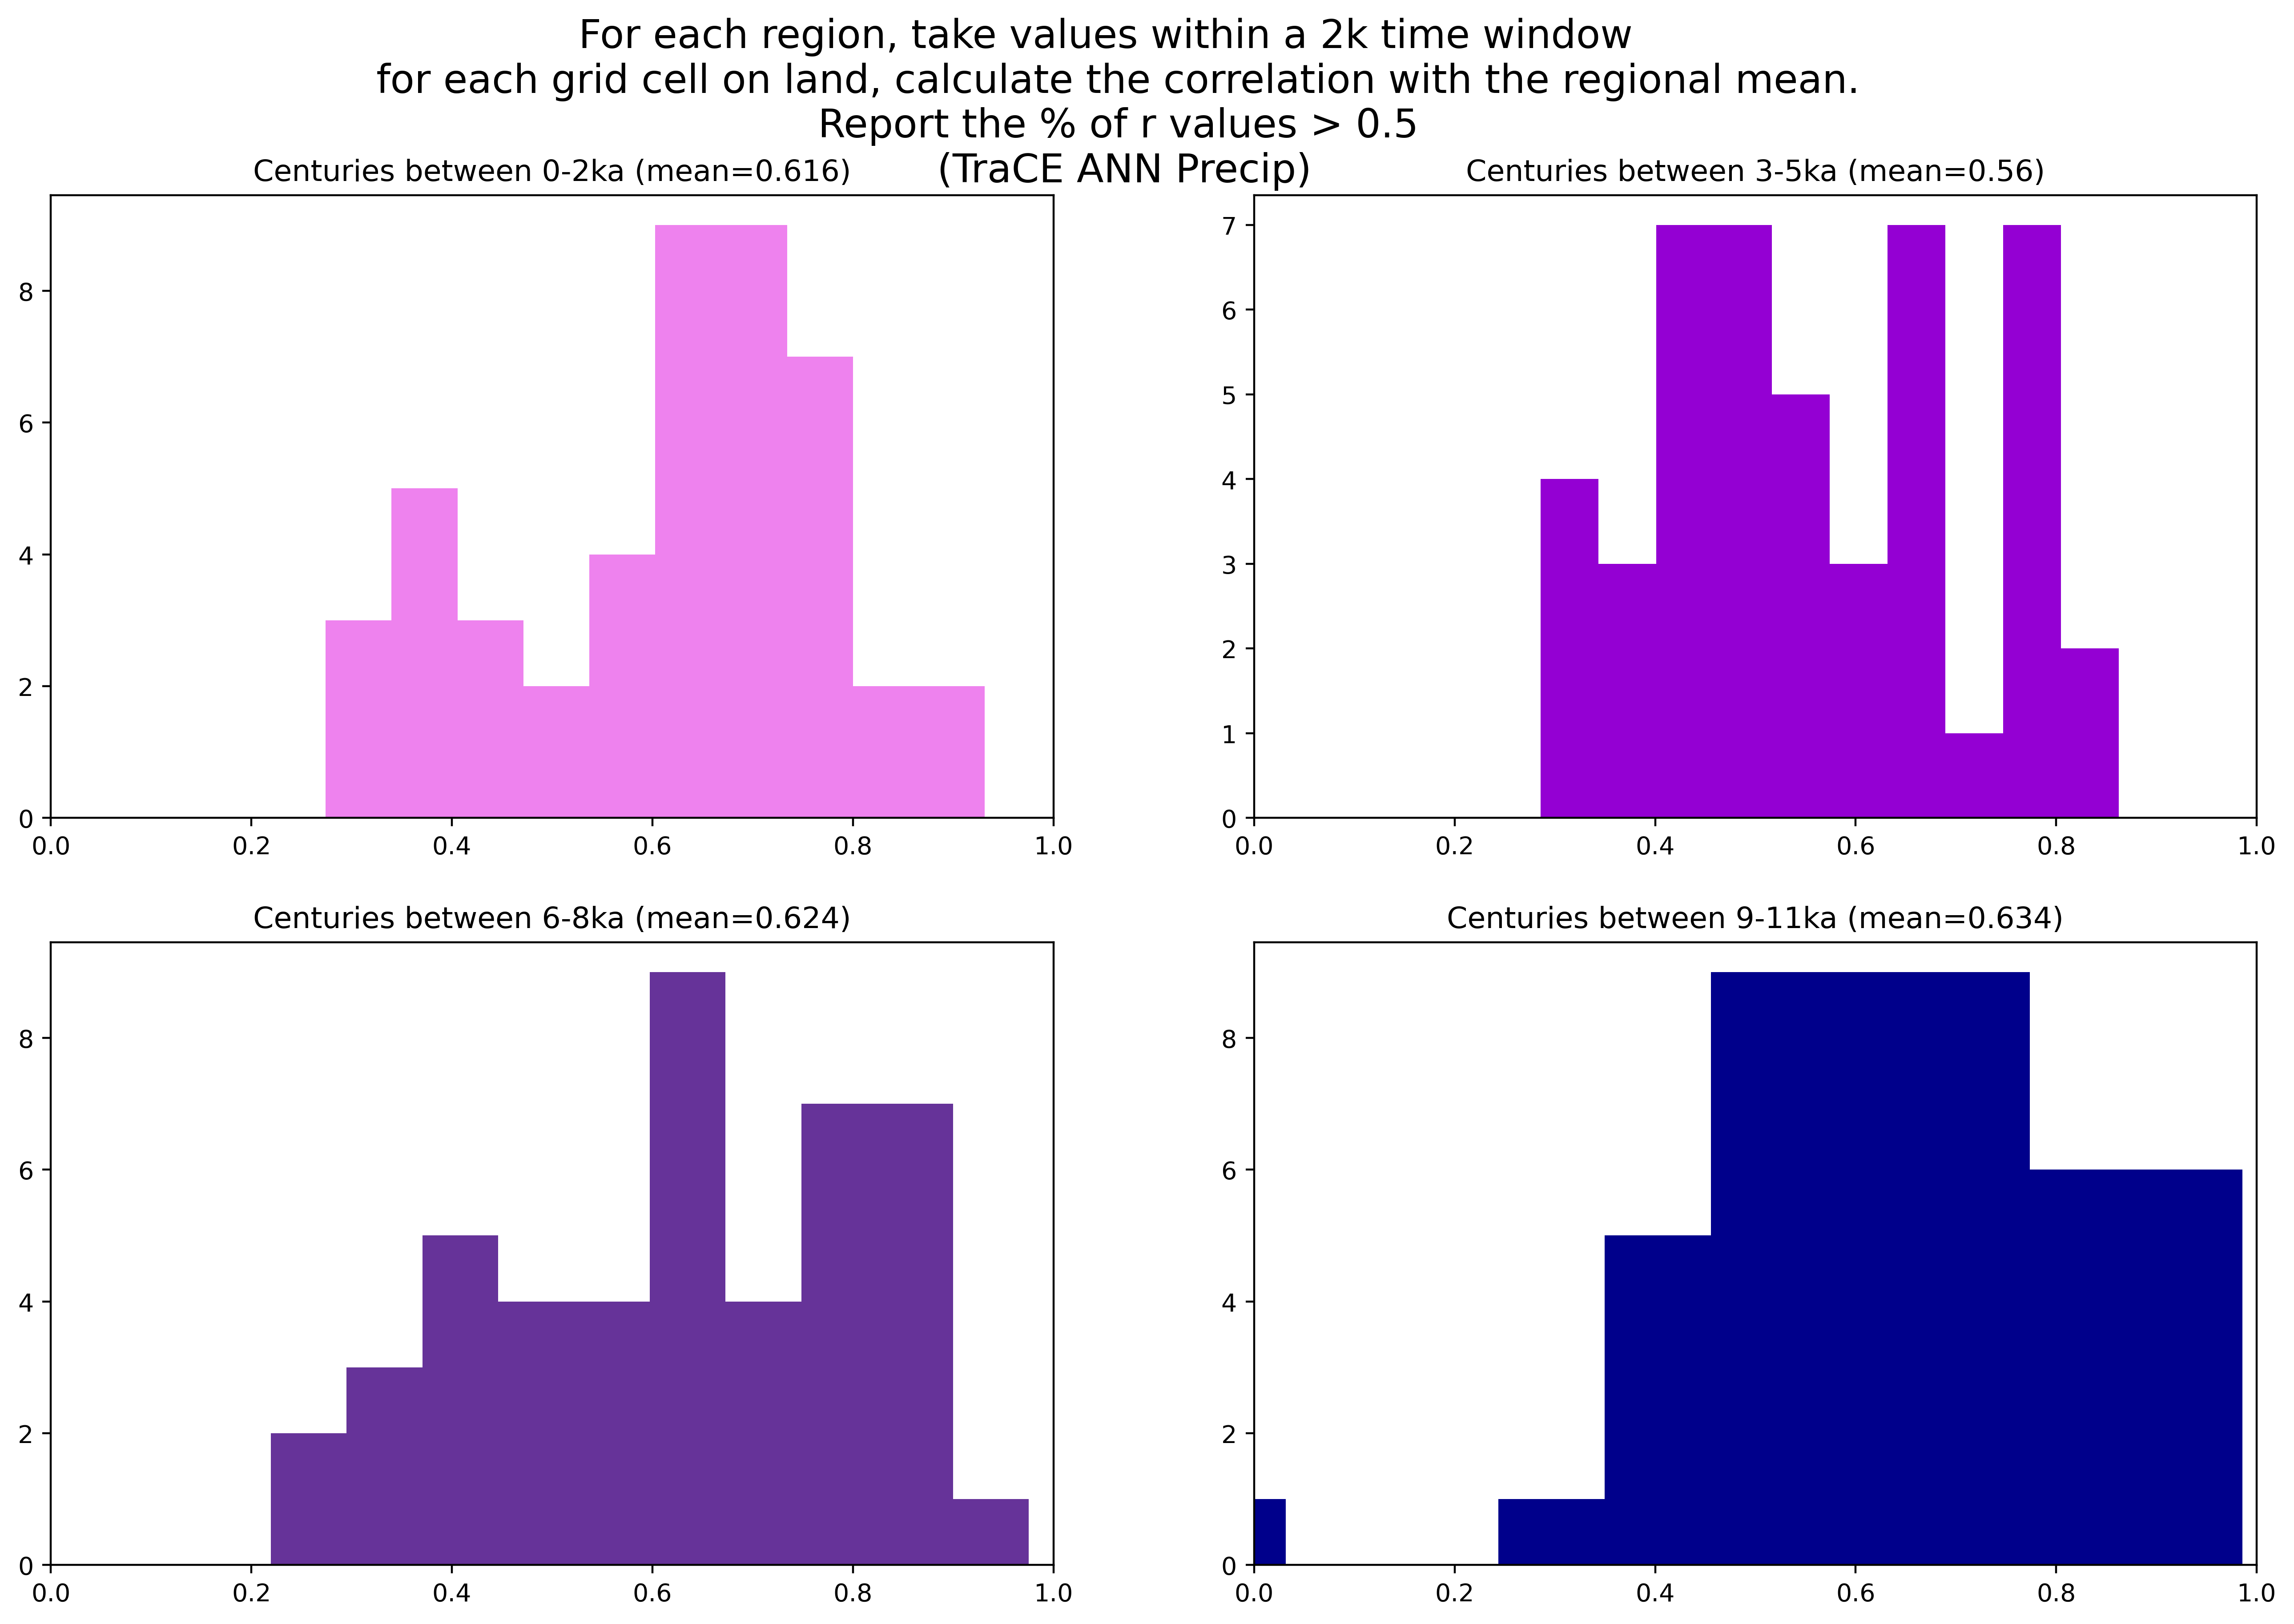

In [6]:
model='trace'
szn='ANN'
import scipy

regioncorrs = {}
for t in [0,3,6,9]:
    print(t)
    #Data
    values = modelData[model][szn].pre.sel(age=slice(t*1000,t*1000+2000))
    lons=data.lon
    lats=data.lat
    #Lat weights
    wghts  = np.cos(np.deg2rad(lats))
    #Refrence regions
    refReg = rm.defined_regions.ar6.land
    refReg = refReg.mask_3D(values)  
    #Land mask
    land   = rm.defined_regions.natural_earth.land_110
    land   = land.mask_3D(lons,lats)   
    land   = np.array([land.squeeze('region').data]*np.shape(refReg)[0])
    #3d mask with land and refRegions
    mask = refReg*land
    out = values.weighted(mask * wghts).mean(dim=("lat", "lon"))
    val = values.where(mask)
    #
    regioncorrs[str(t)]=[]
    for i,region in enumerate(out.region.abbrevs.data):
        valsmean = out[:,i].data
        corrs = []
        for lati in range(len(val.lat)):
            for loni in range(len(val.lon)):
                valsi = val[:,lati,loni,i].data
                if mask[i,lati,loni].data:
                    r,p=scipy.stats.pearsonr(valsi,valsmean)
                    corrs.append(r)
        regioncorrs[str(t)].append(np.mean(corrs))    
#Plot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
    
data1 = regioncorrs[str(0)]
data2 = regioncorrs[str(3)]
data3 = regioncorrs[str(6)]
data4 = regioncorrs[str(9)]

# Create the figure and gridspec
fig = plt.figure(figsize=(16, 10),dpi=400)
gs = fig.add_gridspec(2, 2)

# Create the histograms
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(data1, bins=10, color='violet')
ax1.set_title('Centuries between 0-2ka (mean='+str(np.round(np.mean(data1),3))+')')
ax1.set_xlim(-0,1)
#
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(data2, bins=10, color='darkviolet')
ax2.set_title('Centuries between 3-5ka (mean='+str(np.round(np.mean(data2),3))+')')
ax2.set_xlim(-0,1)

ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(data3, bins=10, color='rebeccapurple')
ax3.set_title('Centuries between 6-8ka (mean='+str(np.round(np.mean(data3),3))+')')
ax3.set_xlim(-0,1)

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(data4, bins=10, color='darkblue')
ax4.set_title('Centuries between 9-11ka (mean='+str(np.round(np.mean(data4),3))+')')
ax4.set_xlim(-0,1)

# Add a title to the figure
fig.suptitle('For each region, take values within a 2k time window  \n for each grid cell on land, calculate the correlation with the regional mean. \n Report the % of r values > 0.5 \n (TraCE ANN Precip)', fontsize=16)

# Show the plot
plt.show()



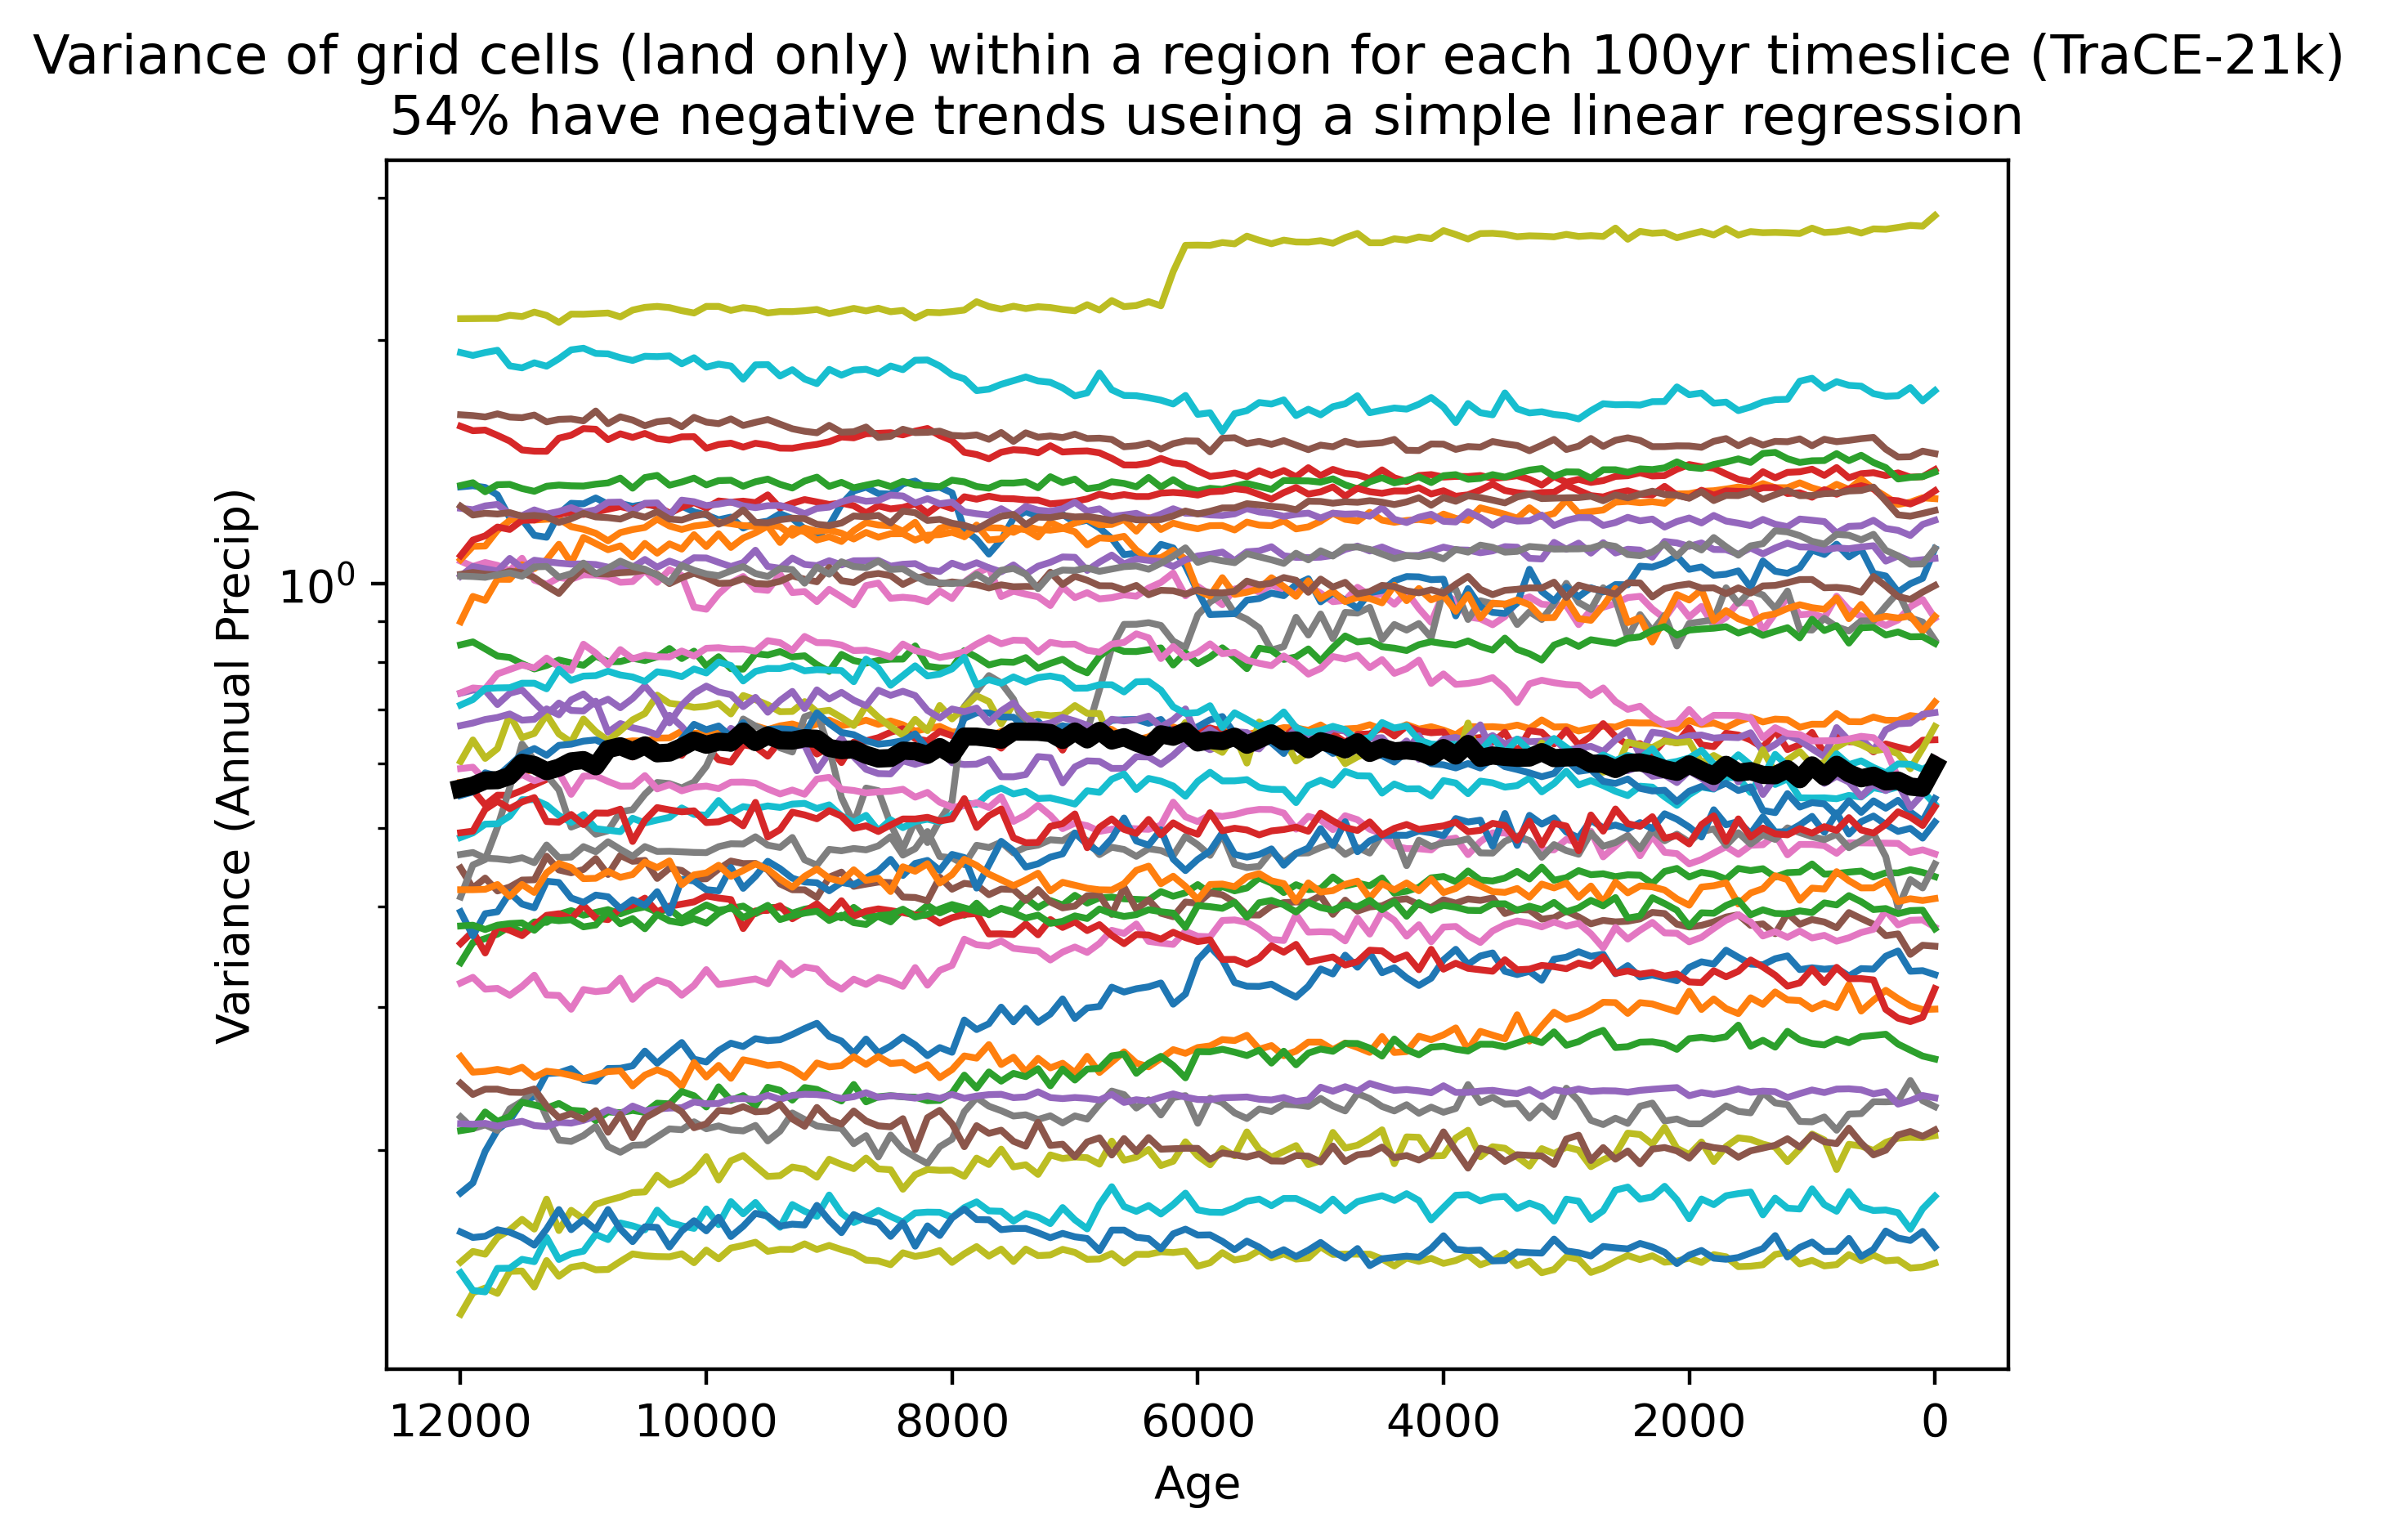

In [7]:
#Does the variance within a region change over time?


values = modelData[model][szn].pre
lons=data.lon
lats=data.lat
#Lat weights
wghts  = np.cos(np.deg2rad(lats))
#Refrence regions
refReg = rm.defined_regions.ar6.land
refReg = refReg.mask_3D(values)  
#Land mask
land   = rm.defined_regions.natural_earth.land_110
land   = land.mask_3D(lons,lats)   
land   = np.array([land.squeeze('region').data]*np.shape(refReg)[0])
#3d mask with land and refRegions
mask = refReg*land
out = values.weighted(mask * wghts).mean(dim=("lat", "lon"))
val = values.where(mask)

pltdata=val.std(dim=['lat','lon'])

trends=pltdata.polyfit(dim = "age", deg = 1).polyfit_coefficients[0]
pct = int(np.sum(trends<0)/len(trends)*100)
#
# Create the ribbon plot
fig, ax = plt.subplots(dpi=400)
#ax.fill_between(pltdata.age, pltdata.quantile(0.25,dim='region'), pltdata.quantile(0.75,dim='region'), alpha=0.2, color='blue')
ax.plot(pltdata.age,pltdata)
ax.plot(pltdata.age,pltdata.median(dim='region'),color='black',lw=4)


# Set the axis labels and title
ax.invert_xaxis()
ax.set_xlabel('Age')
ax.set_ylabel('Variance (Annual Precip)')
ax.set_title('Variance of grid cells (land only) within a region for each 100yr timeslice (TraCE-21k) \n '+str(pct)+'% have negative trends useing a simple linear regression')
ax.set_yscale('log')
# Show the plot
plt.show()